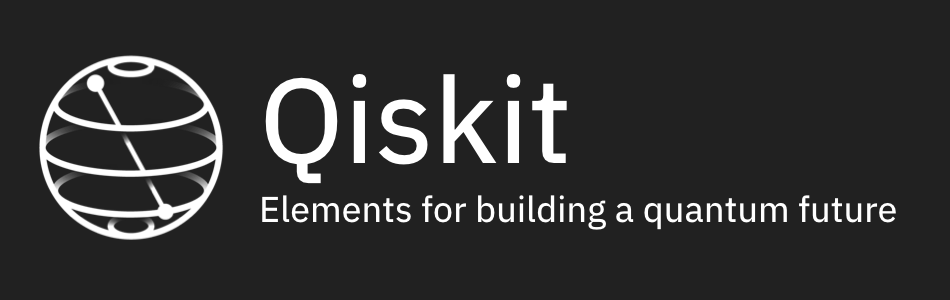

# Qiskit Runtime on IBM Quantum

Prior to becoming an IBM Cloud service, Qiskit Runtime was offered on IBM Quantum. If you have an existing IBM Quantum account, you can continue using Qiskit Runtime on IBM Quantum. 


# qiskit-ibm-runtime

`qiskit-ibm-runtime` provides the interface to interact with Qiskit Runtime. You can, for example, use it to query and execute runtime programs.

## Installation

You can install the `qiskit-ibm-runtime` package using pip:

```
pip install qiskit-ibm-runtime
```

## Account initialization

Before you can start using Qiskit Runtime, you need to initialize your account. You can do this by calling `QiskitRuntimeService` with your IBM Quantum API token, which can be found on the [IBM Quantum accounts page](https://quantum-computing.ibm.com/account).

You can also choose to save your credentials on disk (in the `$HOME/.qiskit/qiskit-ibm.json` file). By doing so, you only need to use `QiskitRuntimeService(channel="ibm_quantum")` in the future to initialize your account.

For more information about account management, such as how to delete or view an account, see [04_account_management.ipynb](04_account_management.ipynb).

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save account on disk.
# QiskitRuntimeService.save_account(channel="ibm_quantum", token=<IBM Quantun API token>)

# The "channel" keyword is not needed if you have only 1 type (ibm_quantum or ibm_cloud) of account saved.
service = QiskitRuntimeService(channel="ibm_quantum")

## Listing programs <a name='listing_program'>

There are three methods that can be used to find metadata of available programs:

- `pprint_programs()`: pretty prints summary metadata of available programs
- `programs()`: returns a list of `RuntimeProgram` instances
- `program()`: returns a single `RuntimeProgram` instance

The metadata of a runtime program includes its ID, name, description, maximum execution time, backend requirements, input parameters, return values, and interim results. Maximum execution time is the maximum amount of time, in seconds, a program can run before being forcibly terminated.

To print the summary metadata of the programs (by default first 20 programs are displayed):

In [2]:
service.pprint_programs(limit=None)

hello-world:
  Name: hello-world
  Description: A sample runtime program.
qaoa:
  Name: qaoa
  Description: Qiskit Runtime QAOA program.
torch-train:
  Name: torch-train
  Description: (DEPRECATED) A runtime program to train hybrid QNN models with Pytorch.
torch-infer:
  Name: torch-infer
  Description: (DEPRECATED) A runtime program to run inference and calculate the scores of Hybrid QNN models with Pytorch.
qasm3-runner:
  Name: qasm3-runner
  Description: A runtime program that takes one or more circuits, converts them to OpenQASM3, compiles them, executes them, and optionally applies measurement error mitigation. This program can also take and execute one or more OpenQASM3 strings. Note that this program can only run on a backend that supports OpenQASM3.
sampler:
  Name: sampler
  Description: Generates quasi-probabilities by sampling quantum circuits.
estimator:
  Name: estimator
  Description: Calculates expectation values of quantum operators.
sample-expval:
  Name: sample-expva

You can use the `limit` and `skip` parameters in `pprint_programs()` and `programs()` to page through all programs. 

You can pass `detailed=True` parameter to `pprint_programs()` to view all the metadata for the programs. 

The program metadata, once fetched, is cached for performance reasons. But you can pass the `refresh=True` parameter  to get the latest data from the server. 

To print the metadata of the program `hello-world`:

In [3]:
program = service.program("hello-world")
print(program)

hello-world:
  Name: hello-world
  Description: A sample runtime program.
  Creation date: 2022-01-05T20:42:53.722892Z
  Update date: 2022-09-27T18:46:45.704881Z
  Max execution time: 600
  Backend requirements:
    Minimum number of qubits: 5
  Input parameters:
    Properties:
        - iterations:
            Default: 1
            Description: Number of iterations to run. Each iteration generates and runs a random circuit.
            Minimum: 0
            Type: integer
            Required: False
  Interim results:
    Properties:
        - counts:
            Description: Histogram data of the circuit result.
            Type: object
            Required: False
        - iteration:
            Description: Iteration number.
            Type: integer
            Required: False
  Returns:
    Description: A string that says 'Hello, World!'.
    Type: string


As you can see from above, the program `hello-world` is a simple program that has only 1 input parameter `iterations`, which indicates how many iterations to run. For each iteration it generates and runs a random 5-qubit circuit and returns the counts as well as the iteration number as the interim results. When the program finishes, it returns the sentence `Hello, World!`. This program can only run for 300 seconds (5 minutes), and requires a backend that has at least 5 qubits.

## Invoking a runtime program <a name='invoking_program'>

You can use the [QiskitRuntimeService.run()](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.html#qiskit_ibm_runtime.QiskitRuntimeService.run) method to invoke a runtime program. This method takes the following parameters:

- `program_id`: ID of the program to run.
- `inputs`: Program input parameters. These input values are passed to the runtime program.
- `options`: Runtime options. These options control the execution environment. Currently the only available option is `backend_name`, which is required.
- `callback`: Callback function to be invoked for any interim results and final result. The callback function will receive two positional parameters: job ID and result.
- `result_decoder`: Optional class used to decode the job result.

Before we run a quantum program, we may want to define a callback function that would process interim results, which are intermediate data provided by a program while it's still running and also the final result. 

As we saw earlier, the metadata of `hello-world` says that its interim results are the iteration number and the counts of the randomly generated circuit. Here we define a simple callback function that just prints these results:

In [4]:
def result_callback(job_id, result):
    print(f"result: {result}")

The following example runs the `hello-world` program with 3 iterations and waits for its result:

In [5]:
# Specify the program inputs here.
program_inputs = {"iterations": 3}

# Specify the backend name.
options = {"backend": "ibmq_qasm_simulator"}

job = service.run(
    program_id="hello-world",
    options=options,
    inputs=program_inputs,
    callback=result_callback,
)

# Printing the job ID in case we need to retrieve it later.
print(f"job id: {job.job_id()}")

# Get the job result - this is blocking and control may not return immediately.
result = job.result()
print(result)

job id: c7f3i9a0jbtu2e0bc440
result: {'iteration': 0, 'counts': {'00000': 1024}}
result: {'iteration': 1, 'counts': {'01111': 119, '01101': 129, '00111': 381, '00101': 395}}
result: {'iteration': 2, 'counts': {'01001': 52, '00001': 44, '01000': 462, '00000': 466}}
result: Hello, World!
Hello, World!


In the example above, we ran `hello-world` on the backend `ibmq_qasm_simulator`. A **backend** is a quantum device or simulator capable of running quantum circuits or pulse schedules, and you can use any backend that you have access to. 

If the backend you choose can be accessed from more than one hub/group/project, the first one that meets the following criteria is selected:

1. The `instance` parameter specified when calling the `run()` method.
2. The default `instance` set when saving the account.
3. A non-open hub/group/project in your account. This is chosen at random if you have multiple. 
4. The open access hub/group/project.

For more information about listing backends and their data see [03_backends.ipynb](03_backends.ipynb).

### Runtime job

The `run()` method returns a [RuntimeJob](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.RuntimeJob.html#qiskit_ibm_runtime.RuntimeJob) instance, which represents the asynchronous execution instance of the program. 

Some of the `RuntimeJob` methods:

- `status()`: Return job status.
- `result()`: Wait for the job to finish and return the final result.
- `cancel()`: Cancel the job.
- `wait_for_final_state()`: Wait for the job to finish.
- `stream_results()`: Stream interim results and final result. This can be used to start streaming the results if a `callback` function was not passed to the `run()` method. This method can also be used to reconnect a lost websocket connection.
- `logs()`: Return job logs.
- `error_message()`: Returns the reason if the job failed and `None` otherwise.
- `job_id()`: Unique identifier of the job.
- `backend()`: The backend where the job is run.

Some of the `RuntimeJob` attributes:

- `program_id`: ID of the program the execution is for.


Refer to the [RuntimeJob API documentation](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.RuntimeJob.html#qiskit_ibm_runtime.RuntimeJob) for a full list of methods and usage. 

<div class="alert alert-block alert-info">
<b>Note:</b> To ensure fairness, there is a maximum execution time for each Qiskit Runtime job. Refer to <a href="https://qiskit.org/documentation/partners/qiskit_ibm_runtime/max_time.html#qiskit-runtime-on-ibm-quantum-ibm-quantum">this documentation</a> on what the time limit is.
</div>

## Retrieving previously run jobs

You can use the [QiskitRuntimeService.job()](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.html#qiskit_ibm_runtime.QiskitRuntimeService.job) method to retrieve a previously executed runtime job. Attributes of this [RuntimeJob](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.RuntimeJob.html#qiskit_ibm_runtime.RuntimeJob) instance can tell you about the execution:

In [6]:
retrieved_job = service.job(job.job_id())
print(
    f"Job {retrieved_job.job_id()} is an execution instance of runtime program {retrieved_job.program_id}."
)
print(
    f"This job ran on backend {retrieved_job.backend()} and had input parameters {retrieved_job.inputs}"
)

Job c7f3i9a0jbtu2e0bc440 is an execution instance of runtime program hello-world.
This job ran on backend ibmq_qasm_simulator and had input parameters {'iterations': 3}


Similarly, you can use [QiskitRuntimeService.jobs()](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.html#qiskit_ibm_runtime.QiskitRuntimeService.jobs) to get a list of jobs. You can specify a limit on how many jobs to return. The default limit is 10:

In [7]:
retrieved_jobs = service.jobs(limit=1)
for rjob in retrieved_jobs:
    print(rjob.job_id())

c7f3i9a0jbtu2e0bc440


## Deleting a job

You can use the [QiskitRuntimeService.delete_job()](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/stubs/qiskit_ibm_runtime.QiskitRuntimeService.html#qiskit_ibm_runtime.QiskitRuntimeService.delete_job) method to delete a job. You can only delete your own jobs, and this action cannot be reversed. 

In [8]:
service.delete_job(job.job_id())

# Next steps

There are additional tutorials in this directory:

- [03_backends.ipynb](03_backends.ipynb) describes how to find a target backend for the Qiskit Runtime program you want to invoke. 
- [04_account_management.ipynb](04_account_management.ipynb) describes how to save, load, and delete your account credentials on disk.
- [05_uploading_program.ipynb](05_uploading_program.ipynb) is an introduction on uploading your custom Qiskit Runtime program.
- [qiskit_runtime_vqe_program.ipynb](sample_vqe_program/qiskit_runtime_vqe_program.ipynb) goes into more details on uploading a real-world program (VQE). 
- [vqe.ipynb](vqe.ipynb) describe how to use the public programs `vqe`. This program is currently only available on Qiskit Runtime on IBM Quantum.

In [9]:
from qiskit.tools.jupyter import *

%qiskit_copyright